<a href="https://colab.research.google.com/github/jfodera/proj-ai-ml/blob/main/homeworks/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy import stats


RANDOM_STATE_CONST=42

# No column size limit
pd.set_option('display.max_columns', None)



# My Classification Problem and Dataset Description



## [NBA 2024 Shots Datset](https://www.kaggle.com/datasets/mexwell/nba-shots?select=NBA_2024_Shots.csv)  
- It is a Binary classification dataset with 10 or more features
- each row represents a shot taken by an NBA player in game from the 2024 NBA Season
### Raw Features
- Self Explanatory: TEAM_NAME, PLAYER_NAME, POSITION_GROUP, POSITION, HOME_TEAM, AWAY_TEAM
- **SEASON_1 & SEASON_2**  
  Season indicator variables

- **TEAM_ID**  
  NBA's unique ID variable of that specific team in their API.

- **PLAYER_ID**  
  NBA's unique ID variable of that specific player in their API.

- **GAME_DATE**  
  Date of the game (M-D-Y // Month-Date-Year).

- **GAME_ID**  
  NBA's unique ID variable of that specific game in their API.

- **EVENT_TYPE**  
  Character variable denoting a shot outcome (`Made Shot` // `Missed Shot`).

- **SHOT_MADE**  
  True/False variable denoting a shot outcome (`True` // `False`).

- **ACTION_TYPE**  
  Description of shot type (layup, dunk, jump shot, etc.).

- **SHOT_TYPE**  
  Type of shot (`2PT` or `3PT`).

- **BASIC_ZONE**  
  Name of the court zone the shot took place in.  
  Values:  
  - Restricted Area  
  - In the Paint (non-RA)  
  - Midrange  
  - Left Corner 3  
  - Right Corner 3  
  - Above the Break  
  - Backcourt

- **ZONE_NAME**  
  Name of the side of court the shot took place in.  
  Values:  
  - left  
  - left side center  
  - center  
  - right side center  
  - right

- **ZONE_ABB**  
  Abbreviation of the side of court.  
  Values:  
  - (L)  
  - (LC)  
  - (C)  
  - (RC)  
  - (R)

- **ZONE_RANGE**  
  Distance range of shot by zones.  
  Values:  
  - Less than 8 ft.  
  - 8-16 ft.  
  - 16-24 ft.  
  - 24+ ft.

- **LOC_X**  
  X coordinate of the shot in the x, y plane of the court (0 to 50).

- **LOC_Y**  
  Y coordinate of the shot in the x, y plane of the court (0 to 50).

- **SHOT_DISTANCE**  
  Distance of the shot with respect to the center of the hoop, in feet.

- **QUARTER**  
  Quarter of the game.

- **MINS_LEFT**  
  Minutes remaining in the quarter.

- **SECS_LEFT**  
  Seconds remaining in the minute of the quarter.

### Features We Will Be working with:

- **TEAM_NAME**  
  Name of the team taking the shot.

- **PLAYER_ID**  
  NBA's unique ID variable of that specific player in their API.


- **HOME_TEAM**  
  Name of the home team in the game.

- **AWAY_TEAM**  
  Name of the away (visiting) team in the game.

- **ACTION_TYPE**  
  Description of shot type (layup, dunk, jump shot, etc.).

- **SHOT_TYPE**  
  Type of shot (`2PT` or `3PT`).

- **BASIC_ZONE**  
  Name of the court zone the shot took place in.  
  Values:  
  - Restricted Area  
  - In the Paint (non-RA)  
  - Midrange  
  - Left Corner 3  
  - Right Corner 3  
  - Above the Break  
  - Backcourt

- **ZONE_ABB**  
  Abbreviation of the side of court.  
  Values:  
  - (L)  
  - (LC)  
  - (C)  
  - (RC)  
  - (R)

- **ZONE_RANGE**  
  Distance range of shot by zones.  
  Values:  
  - Less than 8 ft.  
  - 8-16 ft.  
  - 16-24 ft.  
  - 24+ ft.

- **LOC_X**  
  X coordinate of the shot in the x, y plane of the court (0 to 50).

- **LOC_Y**  
  Y coordinate of the shot in the x, y plane of the court (0 to 50).

- **SHOT_DISTANCE**  
  Distance of the shot with respect to the center of the hoop, in feet.

- **QUARTER**  
  Quarter of the game.



  




# Implementing Decision Tree Classifier

## Preprocessing

### Dropping Unnecessary Columns
here is reasoning for doing so:
  - to provide signal (help discriminate made vs. missed shots)
  - reduce redundancy
  - Avoid irrelevant info
  - Avoid data leakage
    - don't train the model on the target


In [72]:


shotData = pd.read_csv('/content/NBA_2024_Shots.csv')

## These columns for dropped for the reasonings stated about
shotData_pre = shotData.drop(['SEASON_1', 'SEASON_2', 'TEAM_ID', 'PLAYER_NAME', 'POSITION_GROUP', 'GAME_DATE', 'GAME_ID', 'EVENT_TYPE', 'ZONE_NAME', 'MINS_LEFT', 'SECS_LEFT' ], axis=1)
print(shotData_pre.columns.tolist())
shotData_pre.head() # show first 5 rows to make sure correctly loaded

['TEAM_NAME', 'PLAYER_ID', 'POSITION', 'HOME_TEAM', 'AWAY_TEAM', 'SHOT_MADE', 'ACTION_TYPE', 'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER']


,TEAM_NAME,PLAYER_ID,POSITION,HOME_TEAM,AWAY_TEAM,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER
0,Washington Wizards,1629673,SG,MIA,WAS,False,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),C,8-16 ft.,-0.4,17.45,12,1
1,Washington Wizards,1630166,SF,MIA,WAS,True,Jump Shot,3PT Field Goal,Above the Break 3,C,24+ ft.,1.5,30.55,25,1
2,Washington Wizards,1626145,PG,MIA,WAS,True,Driving Layup Shot,2PT Field Goal,Restricted Area,C,Less Than 8 ft.,-3.3,6.55,3,1
3,Washington Wizards,1629673,SG,MIA,WAS,True,Running Finger Roll Layup Shot,2PT Field Goal,Restricted Area,C,Less Than 8 ft.,-1.0,5.85,1,1
4,Washington Wizards,1626145,PG,MIA,WAS,True,Cutting Layup Shot,2PT Field Goal,Restricted Area,C,Less Than 8 ft.,-0.0,6.25,1,1


### Missing Value Audit

In [73]:
print(shotData_pre.isna().sum().sort_values(ascending=False)) #note that this creates a data frame simple with isna true or false for each peice
print("\nPercentage missing:\n", shotData_pre.isna().sum().sort_values(ascending=False) / len(shotData_pre) * 100)

POSITION         1264
TEAM_NAME           0
PLAYER_ID           0
HOME_TEAM           0
AWAY_TEAM           0
SHOT_MADE           0
ACTION_TYPE         0
SHOT_TYPE           0
BASIC_ZONE          0
ZONE_ABB            0
ZONE_RANGE          0
LOC_X               0
LOC_Y               0
SHOT_DISTANCE       0
QUARTER             0
dtype: int64

Percentage missing:
 POSITION         0.577958
TEAM_NAME        0.000000
PLAYER_ID        0.000000
HOME_TEAM        0.000000
AWAY_TEAM        0.000000
SHOT_MADE        0.000000
ACTION_TYPE      0.000000
SHOT_TYPE        0.000000
BASIC_ZONE       0.000000
ZONE_ABB         0.000000
ZONE_RANGE       0.000000
LOC_X            0.000000
LOC_Y            0.000000
SHOT_DISTANCE    0.000000
QUARTER          0.000000
dtype: float64


#### As a result of the audit, we are also droppign the position column

In [74]:
shotData_pre = shotData_pre.drop(['POSITION'], axis=1);
shotData_pre.head()

,TEAM_NAME,PLAYER_ID,HOME_TEAM,AWAY_TEAM,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER
0,Washington Wizards,1629673,MIA,WAS,False,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),C,8-16 ft.,-0.4,17.45,12,1
1,Washington Wizards,1630166,MIA,WAS,True,Jump Shot,3PT Field Goal,Above the Break 3,C,24+ ft.,1.5,30.55,25,1
2,Washington Wizards,1626145,MIA,WAS,True,Driving Layup Shot,2PT Field Goal,Restricted Area,C,Less Than 8 ft.,-3.3,6.55,3,1
3,Washington Wizards,1629673,MIA,WAS,True,Running Finger Roll Layup Shot,2PT Field Goal,Restricted Area,C,Less Than 8 ft.,-1.0,5.85,1,1
4,Washington Wizards,1626145,MIA,WAS,True,Cutting Layup Shot,2PT Field Goal,Restricted Area,C,Less Than 8 ft.,-0.0,6.25,1,1


### Split into X and Y


In [75]:
full_df_sample = shotData_pre.sample(n=100000, random_state=RANDOM_STATE_CONST) # Random Reduction with random seed for runtime purposes

shotData_y = shotData_pre['SHOT_MADE'];
shotData_x = shotData_pre.drop(['SHOT_MADE'], axis=1);

shotData_y.head()

,SHOT_MADE
0,False
1,True
2,True
3,True
4,True


### Non-Numeric to Numeric Conversion

In [76]:

cat_cols = shotData_x.select_dtypes(include=['object','category']).columns.tolist()
# The rest, produces a list of column names
numeric_cols = [col for col in shotData_x.columns if col not in cat_cols]

# Preprocessor: only encode categoricals; keep numerics as-is
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
         cat_cols),
    ],
    remainder='passthrough'   # important: keeps numeric columns
)

# This order allows of the fitted preprocessor later for later
preprocessor.fit(shotData_x)                # learns the encoding mappings from training data
shotData_x_trans = preprocessor.transform(shotData_x) #transforms the data based on the rules assigned to prepreocessor
feature_names = preprocessor.get_feature_names_out()
# Ordered in the following way: 1. All transformed columns first (in the order you listed them in cat_cols), 2. Then all remainder (passthrough) columns (in their original relative order)
print(feature_names.tolist()) # Helps to map values to orig
np.set_printoptions(
    precision=2,        # 2 decimal places
    suppress=True,      # no 1.63e+06 notation
    floatmode='fixed',  # force fixed decimals
    linewidth=180       # wider lines so less wrapping
)
for i in range(5):
    print(shotData_x_trans[i])
shotData_x.head()





['cat__TEAM_NAME', 'cat__HOME_TEAM', 'cat__AWAY_TEAM', 'cat__ACTION_TYPE', 'cat__SHOT_TYPE', 'cat__BASIC_ZONE', 'cat__ZONE_ABB', 'cat__ZONE_RANGE', 'remainder__PLAYER_ID', 'remainder__LOC_X', 'remainder__LOC_Y', 'remainder__SHOT_DISTANCE', 'remainder__QUARTER']
[     29.00      15.00      29.00       9.00       0.00       2.00       1.00       2.00 1629673.00      -0.40      17.45      12.00       1.00]
[     29.00      15.00      29.00      22.00       1.00       0.00       1.00       1.00 1630166.00       1.50      30.55      25.00       1.00]
[     29.00      15.00      29.00      11.00       0.00       5.00       1.00       4.00 1626145.00      -3.30       6.55       3.00       1.00]
[     29.00      15.00      29.00      32.00       0.00       5.00       1.00       4.00 1629673.00      -1.00       5.85       1.00       1.00]
[     29.00      15.00      29.00       4.00       0.00       5.00       1.00       4.00 1626145.00      -0.00       6.25       1.00       1.00]


,TEAM_NAME,PLAYER_ID,HOME_TEAM,AWAY_TEAM,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER
0,Washington Wizards,1629673,MIA,WAS,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),C,8-16 ft.,-0.4,17.45,12,1
1,Washington Wizards,1630166,MIA,WAS,Jump Shot,3PT Field Goal,Above the Break 3,C,24+ ft.,1.5,30.55,25,1
2,Washington Wizards,1626145,MIA,WAS,Driving Layup Shot,2PT Field Goal,Restricted Area,C,Less Than 8 ft.,-3.3,6.55,3,1
3,Washington Wizards,1629673,MIA,WAS,Running Finger Roll Layup Shot,2PT Field Goal,Restricted Area,C,Less Than 8 ft.,-1.0,5.85,1,1
4,Washington Wizards,1626145,MIA,WAS,Cutting Layup Shot,2PT Field Goal,Restricted Area,C,Less Than 8 ft.,-0.0,6.25,1,1


## Visualizing Decision Tree Structures with Different Parameters

### Tree 1


#### Implementation

In [77]:

classification_tree1 = tree.DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=7,       # prevent overfitting
    max_features=None,          # if 'sqrt' or other, the features are randomly sampled every new split
    min_impurity_decrease=0.0001
) #init

# Train our decision tree (tree induction + pruning)
clf1 = classification_tree1.fit(shotData_x_trans, shotData_y)



#### Plot

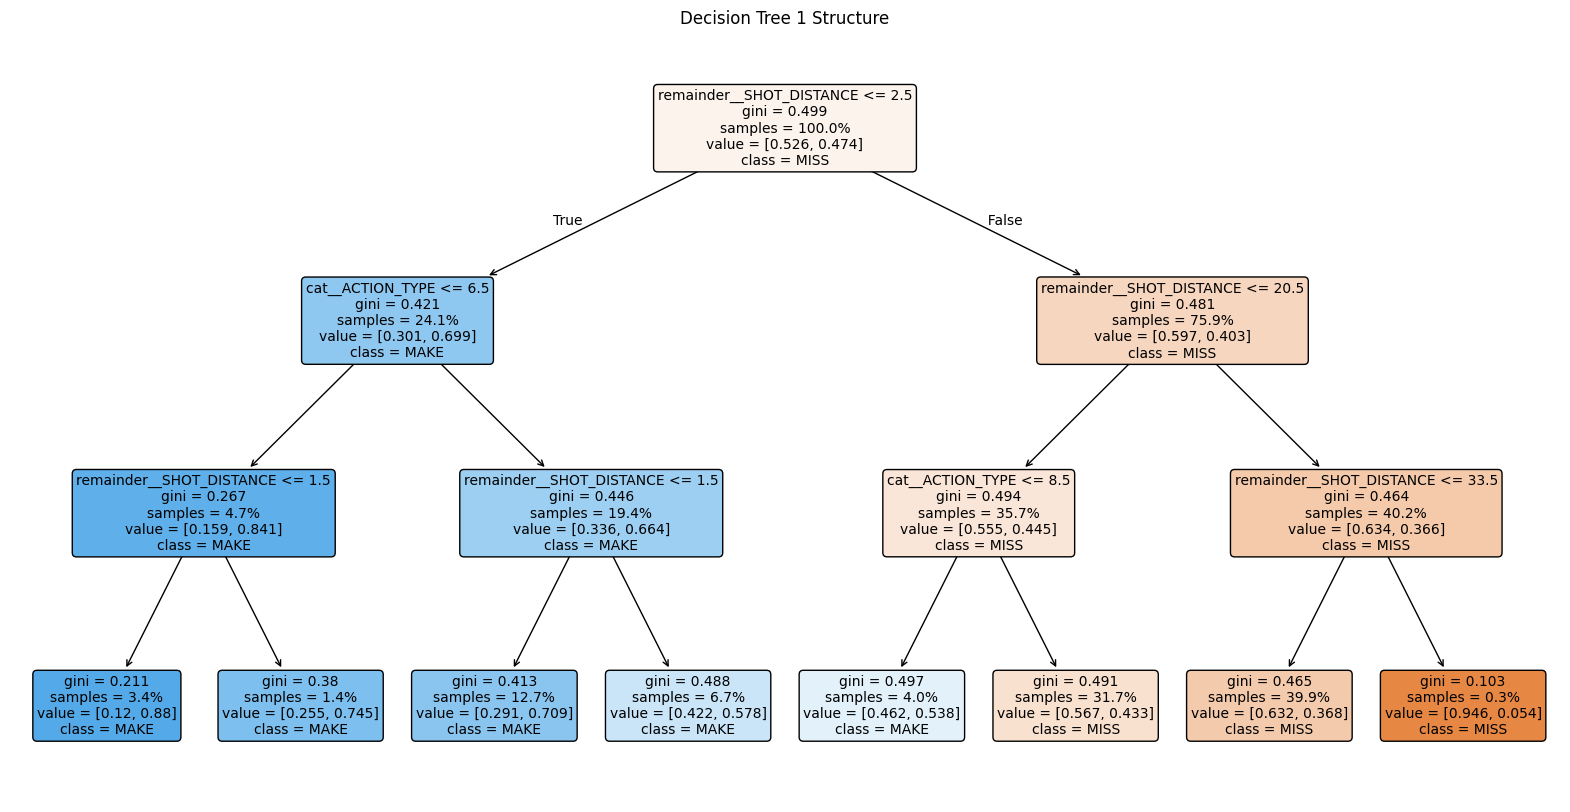

In [78]:
plt.figure(figsize=(20, 10))          # Adjust size for readability
plot_tree(
    clf1,
    feature_names = preprocessor.get_feature_names_out().tolist(),   # list of column names, e.g. preprocessor.get_feature_names_out()
    class_names   = ['MISS', 'MAKE'], # class0,class1. false, true
    filled        = True,             # color nodes by majority class
    rounded       = True,
    fontsize      = 10,               # helpful for larger trees
    impurity      = True,             # show Gini/entropy
    proportion    = True             # or True to show % instead of counts
)
plt.title("Decision Tree 1 Structure")
plt.show()



### Tree 2


#### Implementation

In [79]:

classification_tree2 = tree.DecisionTreeClassifier(
    max_depth=8,
    min_samples_split=3000,       # prevent overfitting
    max_features=None,          # if 'sqrt' or other, the features are randomly sampled every new split
    min_impurity_decrease=0.001
) #init

# Train our decision tree (tree induction + pruning)
clf2 = classification_tree2.fit(shotData_x_trans, shotData_y)



#### Plot

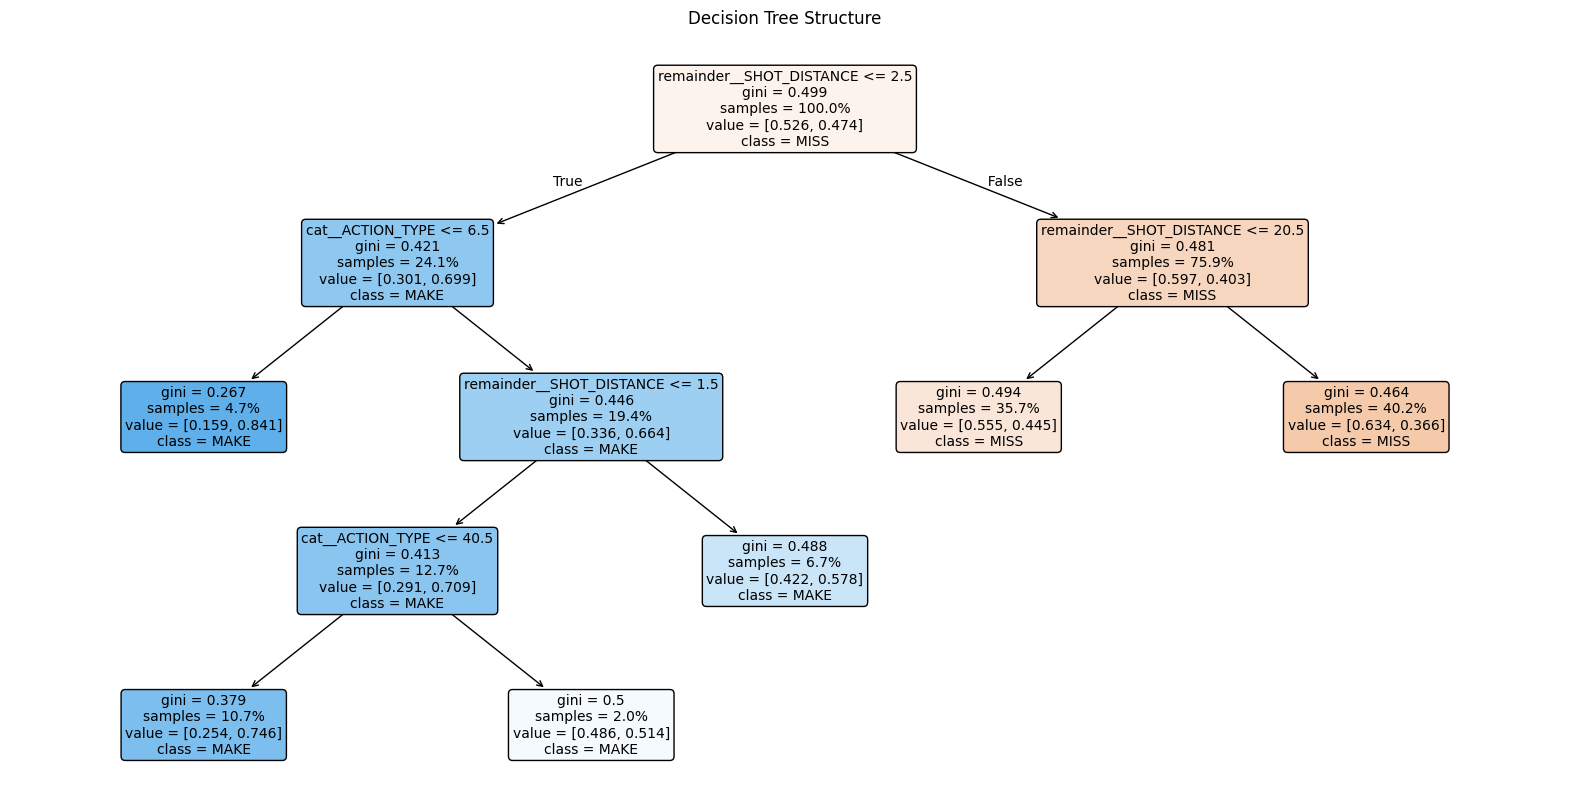

In [80]:
plt.figure(figsize=(20, 10))          # Adjust size for readability
plot_tree(
    clf2,
    feature_names = preprocessor.get_feature_names_out().tolist(),   # list of column names, e.g. preprocessor.get_feature_names_out()
    class_names   = ['MISS', 'MAKE'], # class0,class1. false, true
    filled        = True,             # color nodes by majority class
    rounded       = True,
    fontsize      = 10,               # helpful for larger trees
    impurity      = True,             # show Gini/entropy
    proportion    = True             # or True to show % instead of counts
)
plt.title("Decision Tree Structure")
plt.show()

### Tree 3


#### Implementation

In [81]:

classification_tree3 = tree.DecisionTreeClassifier(
    max_depth=8,
    min_samples_split=2000,       # prevent overfitting
    max_features=None,          # if 'sqrt' or other, the features are randomly sampled every new split
    min_impurity_decrease=0.0001
) #init

# Train our decision tree (tree induction + pruning)
clf3 = classification_tree3.fit(shotData_x_trans, shotData_y)



#### Plot

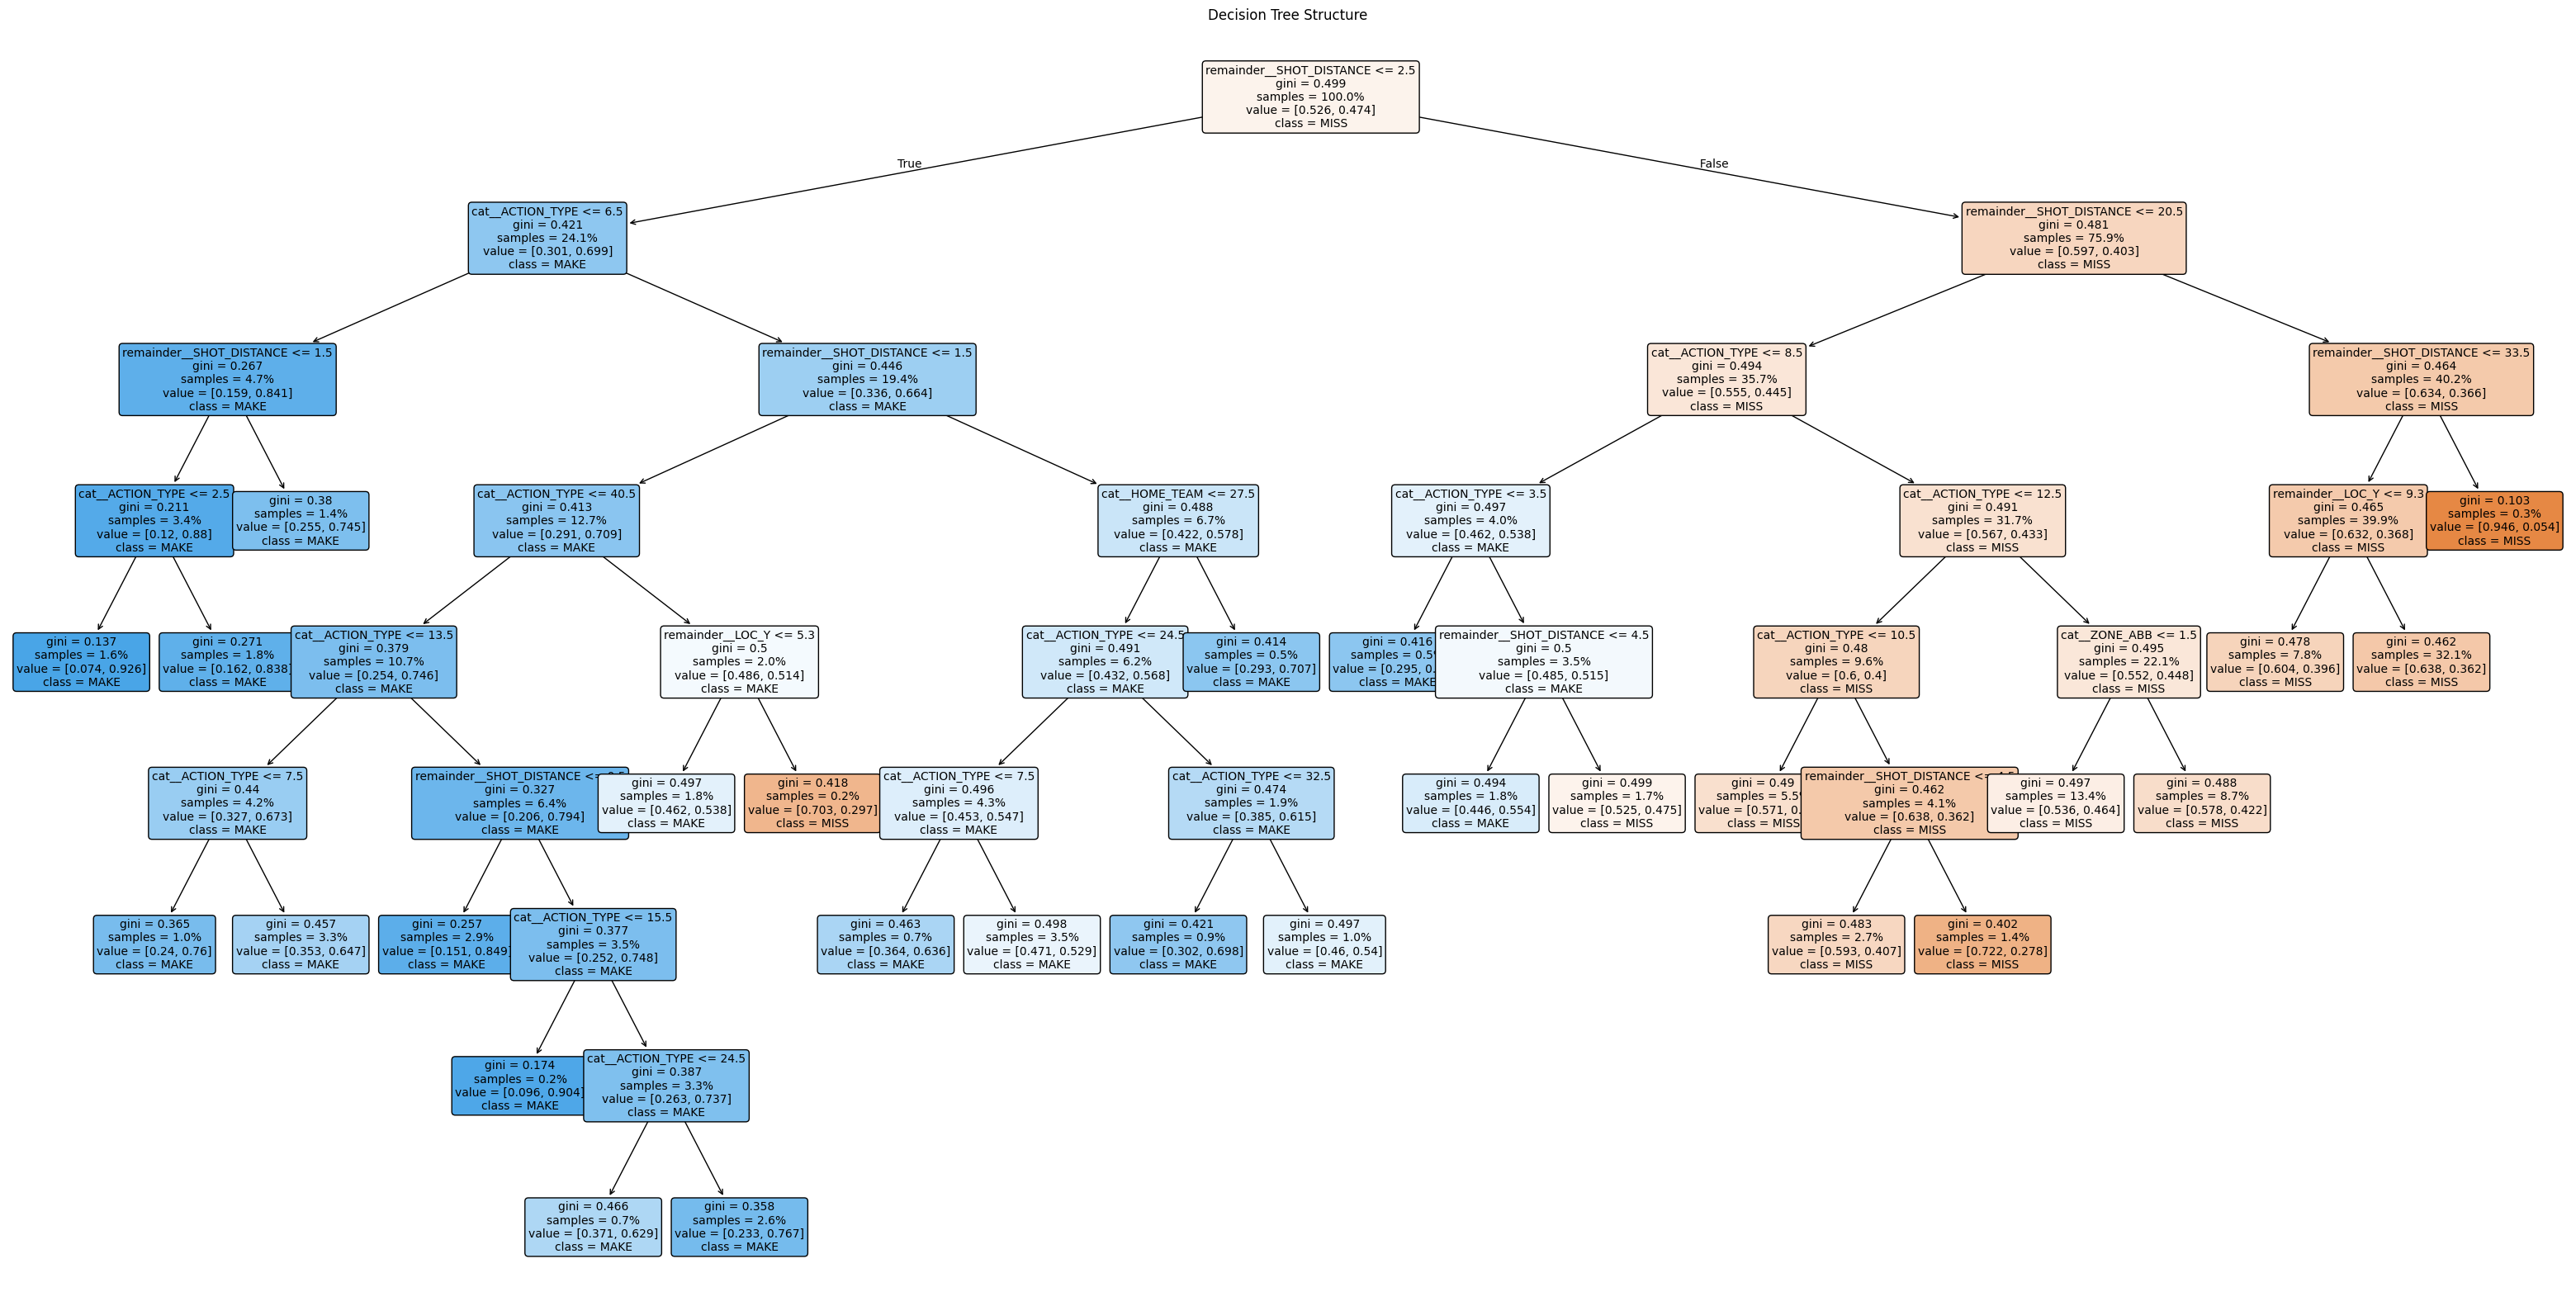

In [82]:
plt.figure(figsize=(40, 20))          # Adjust size for readability
plot_tree(
    clf3,
    feature_names = preprocessor.get_feature_names_out().tolist(),   # list of column names, e.g. preprocessor.get_feature_names_out()
    class_names   = ['MISS', 'MAKE'], # class0,class1. false, true
    filled        = True,             # color nodes by majority class
    rounded       = True,
    fontsize      = 10,               # helpful for larger trees
    impurity      = True,             # show Gini/entropy
    proportion    = True             # or True to show % instead of counts
)
plt.title("Decision Tree Structure")
plt.show()

### Comments
For the first Tree we can see that I kept the `max_depth` reasonably low along with a very low bar for the `min_samples_split`. Overfitting was primarily halted by the low depth. This is because the other parameters like `min_samples_split`, `max_features`, and `min_impurity_decrease` were very forgiving and leniant. The leanancy of the afermentioned three features is what allowed the tree to be completley filled out in its maximum depth of 3. In tree #2, changing the `max_depth` to 8 had much less of a drastic fit then you would think. This is primarily because I jacked up the `min_samples_split` to 3000 instead of the original 7. This resulted in a much higher bar to split and prevented the tree from fully filling out and utilizing that maximum depth on both sides. The main cause of the lack of the right `MISS` side being filled out was most likely the increase in the `min_impurity_decrease` from 0.0001 to 0.001. Lastly, for tree #3 we loosened up the `min_samples_split` and `min_impurity_decrease` while keeping the `max_depth` the same. This resulted in a much more filled out version of the tree as there was less stringend requirements on splits. It seems as thought the main reason for preventing splits was the `min_samples_split` being at 2000 as this was still significantly higher than the first one.

## Sensitivity Analysis

### Research

#### What it is?
- In simplest terms it is analyzing how changes in inputs effect the outputs.
  - MathWorks defines it as the study of how uncertainty in the output of a model can be attributed to different sources of uncertainty in the model input[[1]](http://mathworks.com/help/sldo/ug/what-is-sensitivity-analysis.html)
- It helps to assess model robustness and identify influential factors[[2]](https://arxiv.org/pdf/2312.13234).
- You can evaluate the importance and affect of these inputs by manipulating them to analyze output or feature changes[[2]](https://arxiv.org/pdf/2312.13234).
- Can help to quantify the relationship between model performance and dataset size (one of the inputs) for given prediction problem[[3]](https://machinelearningmastery.com/sensitivity-analysis-of-dataset-size-vs-model-performance/).


#### How it is Preformed
After doing some research on what sensitivity analysis is, I looked into the best ways on how to preform it in the context of decision tree classifiers. I came across some Scikit-learn Documentation about *permutation feature importance*. This is a model inspection technique that is meant to measure how much certain features contribute to a models preformance. It involves shuffling the values of a single feature randomly and measuring the affect doing this has on the models score. This technique is also known as perturbing features[[4]](https://scikit-learn.org/stable/modules/permutation_importance.html).


#### Citations
[1]The MathWorks, Inc. "What Is Sensitivity Analysis?" MATLAB & Simulink, The MathWorks, Inc., 2026, mathworks.com/help/sldo/ug/what-is-sensitivity-analysis.html. Accessed 5 Feb. 2026.   

[2]Scholbeck, Christian A., et al. "Position Paper: Bridging the Gap Between Machine Learning and Sensitivity Analysis." arXiv, submitted 20 Dec. 2023, last revised 10 Sept. 2024, arXiv:2312.13234v2. PDF, https://arxiv.org/pdf/2312.13234.  

[3]Brownlee, Jason. "Sensitivity Analysis of Dataset Size vs. Model Performance." Machine Learning Mastery, 1 Feb. 2021, machinelearningmastery.com/sensitivity-analysis-of-dataset-size-vs-model-performance. Accessed 5 Feb. 2026.   

[4]scikit-learn developers. "5.2. Permutation Feature Importance." scikit-learn 1.8.0 documentation, scikit-learn, 2025, scikit-learn.org/stable/modules/permutation_importance.html. Accessed 5 Feb. 2026.

### Implementation

After doing my research, I will move forward by preforming sensitivity analysis via computing permutation imporance. Focusing the results on the folowing input features:
  - `SHOT_DISTANCE`
  - `ACTION_TYPE`

In [83]:
# 4. Compute permutation importance
result = permutation_importance(
    clf3,
    shotData_x_trans, shotData_y,
    n_repeats=5,
    random_state=RANDOM_STATE_CONST,
    n_jobs=-1,                # use all cores
    scoring='accuracy'
)

['cat__TEAM_NAME', 'cat__HOME_TEAM', 'cat__AWAY_TEAM', 'cat__ACTION_TYPE', 'cat__SHOT_TYPE', 'cat__BASIC_ZONE', 'cat__ZONE_ABB', 'cat__ZONE_RANGE', 'remainder__PLAYER_ID', 'remainder__LOC_X', 'remainder__LOC_Y', 'remainder__SHOT_DISTANCE', 'remainder__QUARTER']

Permutation Importance for selected features:
ACTION_TYPE : 0.00950
SHOT_DISTANCE: 0.10266


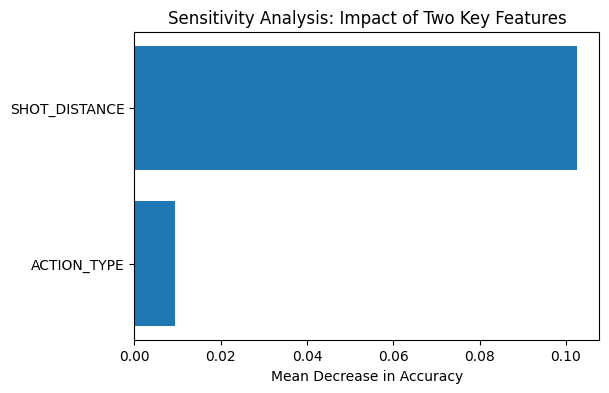

In [84]:

importances_mean = result.importances_mean
sorted_idx = importances_mean.argsort()


print(feature_names.tolist())
dist_idx = np.where(feature_names == 'cat__ACTION_TYPE')[0][0]
locx_idx  = np.where(feature_names == 'remainder__SHOT_DISTANCE')[0][0]

print("\nPermutation Importance for selected features:")
print(f"ACTION_TYPE : {importances_mean[dist_idx]:.5f}")
print(f"SHOT_DISTANCE: {importances_mean[locx_idx]:.5f}")

selected_features = ['ACTION_TYPE', 'SHOT_DISTANCE']
selected_idx = [dist_idx, locx_idx]
plt.figure(figsize=(6,4))
plt.barh(['ACTION_TYPE', 'SHOT_DISTANCE'], importances_mean[selected_idx])
plt.xlabel("Mean Decrease in Accuracy")
plt.title("Sensitivity Analysis: Impact of Two Key Features")
plt.show()

### Comments on Results
The sensitivity analysis, conducted via permutation importance on the final model, reveals that `SHOT_DISTANCE` is overwhelmingly the most influential feature, causing a mean decrease in accuracy of approximately 0.103 when its values are randomly shuffled. This substantial drop underscores that the physical distance from the basket serves as the primary determinant of shot success, aligning with intuition. In contrast, `ACTION_TYPE` exhibits a much smaller impact, with a mean decrease of only about 0.0095, indicating that while the specific mechanics or style of the shot (such as layup, jump shot, or dunk) do contribute useful signal, they play a substantially more secondary role compared to spatial location. Overall, the roughly tenfold difference in importance between these two features highlights that the model's decision boundary is shaped predominantly by contextual geometry rather than by the descriptive classification of the shot attempt itself.

# Implementing Bagging and Boosting

## Algorithm Implementation
- Bagging Algorithim: **Random Forest**
- Boosting Algorithm: **Gradient Boost**

### Defining Params and Variables

In [85]:
## Defining Params

rf = RandomForestClassifier(
    n_estimators=50,           # tad smaller for runtime
    max_depth=8,                # slightly deeper than single tree
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',        # typ forest setting
    random_state=RANDOM_STATE_CONST,
    n_jobs=-1                   # use all cores
)

gb = GradientBoostingClassifier(
    n_estimators=50,            # tad smaller for runtime
    learning_rate=0.1,          # controls contribution of each tree
    max_depth=4,                # typ shallow trees in GB
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,              # stochastic gradient boosting
    random_state=RANDOM_STATE_CONST
)

# Defining val Metrics
## Naming them the same for easy understanding
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'f1': 'f1'
}

fold_numbers = [5, 10, 15]
results = []
# For paired t-test
rf_acc_per_fold = []
gb_acc_per_fold = []
dt_acc_per_fold  = []

### Fitting-CV-Output (long runtime)
*Note also did CV for clf1 from above for later*

In [86]:
for n_folds in fold_numbers:
    print(f"\nRunning {n_folds}-fold Stratified CV...")

    cv = StratifiedKFold(
        n_splits=n_folds,
        shuffle=True,
        random_state=RANDOM_STATE_CONST
    )

    rf_scores = cross_validate(
        rf,
        shotData_x_trans,
        shotData_y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    rf_acc_per_fold.append(rf_scores['test_accuracy'])


    gb_scores = cross_validate(
        gb,
        shotData_x_trans,
        shotData_y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    gb_acc_per_fold.append(gb_scores['test_accuracy'])

    row_rf = {
        'Folds': n_folds,
        'Model': 'Random Forest',
        'Accuracy':  rf_scores['test_accuracy'].mean(),
        'Precision': rf_scores['test_precision'].mean(),
        'F1':        rf_scores['test_f1'].mean(),
    }
    results.append(row_rf)

    row_gb = {
        'Folds': n_folds,
        'Model': 'Gradient Boosting',
        'Accuracy':  gb_scores['test_accuracy'].mean(),
        'Precision': gb_scores['test_precision'].mean(),
        'F1':        gb_scores['test_f1'].mean(),
    }
    results.append(row_gb)

# For Decision Tree t-tests
cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE_CONST)
# NOTE: USED CLF 1
clf1_scores = cross_validate(clf1, shotData_x_trans, shotData_y, cv=cv10, scoring=scoring, n_jobs=-1)
dt_acc_per_fold.append(clf1_scores['test_accuracy'])



Running 5-fold Stratified CV...
we are here

Running 10-fold Stratified CV...
we are here

Running 15-fold Stratified CV...
we are here


### Formatting Output of

In [87]:

results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("Cross-Validation Results Summary")
print("="*60)
print(results_df.round(4).to_string(index=False))




print("\n" + "="*50)
print("Model Rankings by Metric")
print("="*50)

# Sort descending (higher score = better)
ranked_accuracy = results_df.sort_values('Accuracy', ascending=False)[['Model', 'Folds', 'Accuracy']].reset_index(drop=True)
ranked_precision = results_df.sort_values('Precision', ascending=False)[['Model', 'Folds', 'Precision']].reset_index(drop=True)
ranked_f1 = results_df.sort_values('F1', ascending=False)[['Model', 'Folds', 'F1']].reset_index(drop=True)

print("\nAccuracy Ranking:")
print(ranked_accuracy.round(4))

print("\nPrecision Ranking:")
print(ranked_precision.round(4))

print("\nF1-score Ranking:")
print(ranked_f1.round(4))


Cross-Validation Results Summary
 Folds             Model  Accuracy  Precision     F1
     5     Random Forest    0.6274     0.6864 0.5014
     5 Gradient Boosting    0.6296     0.6950 0.5001
    10     Random Forest    0.6271     0.6855 0.5014
    10 Gradient Boosting    0.6296     0.6945 0.5005
    15     Random Forest    0.6272     0.6850 0.5021
    15 Gradient Boosting    0.6296     0.6947 0.5004

Model Rankings by Metric

Accuracy Ranking:
               Model  Folds  Accuracy
0  Gradient Boosting      5    0.6296
1  Gradient Boosting     15    0.6296
2  Gradient Boosting     10    0.6296
3      Random Forest      5    0.6274
4      Random Forest     15    0.6272
5      Random Forest     10    0.6271

Precision Ranking:
               Model  Folds  Precision
0  Gradient Boosting      5     0.6950
1  Gradient Boosting     15     0.6947
2  Gradient Boosting     10     0.6945
3      Random Forest      5     0.6864
4      Random Forest     10     0.6855
5      Random Forest     15   

## Comments
Gradient Boosting consistently outperforms Random Forest in accuracy and precision across all tested fold counts (5, 10, and 15 folds), achieving the highest values in every configuration with very stable performance regardless of the number of folds. Random Forest shows slightly lower but still competitive accuracy and precision, with minimal variation as the number of folds increases from 5 to 15. In contrast, Random Forest achieves higher F1-scores than Gradient Boosting in all fold settings, with its best result (0.5021) occurring at 15 folds and its lowest (0.5014) at both 5 and 10 folds. Gradient Boosting’s F1-scores remain consistently lower and show almost no improvement with more folds, staying very close to 0.500 across 5, 10, and 15 folds. Both models exhibit remarkably stable behavior as the number of folds increases, with differences between 5-fold and 15-fold results being negligible (less than 0.003 in most cases). This stability suggests that the dataset size and class distribution are sufficient for reliable cross-validation estimates even with only 5 folds.   

The ranking changes across metrics because accuracy and precision reward models that minimize overall errors and false positives, where Gradient Boosting’s sequential error correction gives it a clear advantage. F1-score, however, balances precision and recall equally, and Random Forest’s bagging strategy produces more robust recall by averaging diverse trees, leading to better harmonic mean performance. The choice of metric therefore highlights different strengths: Gradient Boosting excels at confident positive predictions, while Random Forest provides more balanced classification overall. The near-identical results across different fold counts further indicate that the observed ranking differences are driven by algorithmic properties rather than evaluation instability.

##

# Comparing The Three Models

## Creating Confustion Matrix

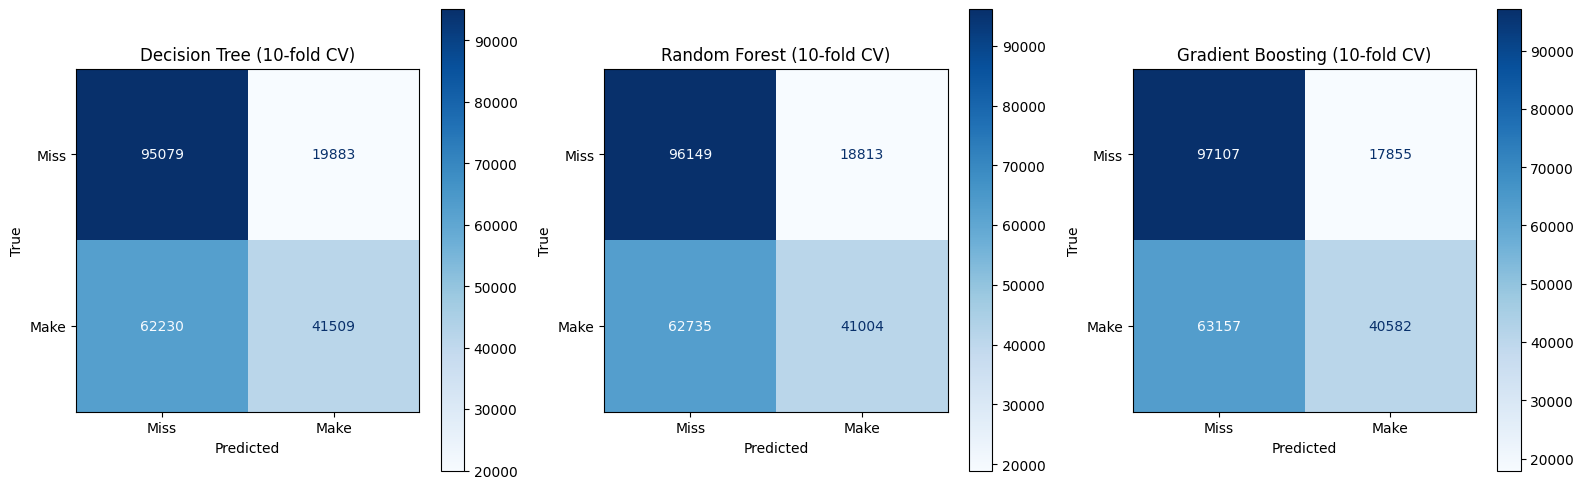

In [89]:
cv = StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=RANDOM_STATE_CONST
)

y_pred_dt = cross_val_predict(
    clf1,
    shotData_x_trans,
    shotData_y,
    cv=cv,
    n_jobs=-1
)

y_pred_rf = cross_val_predict(
    rf,
    shotData_x_trans,
    shotData_y,
    cv=cv,
    n_jobs=-1
)


y_pred_gb = cross_val_predict(
    gb,
    shotData_x_trans,
    shotData_y,
    cv=cv,
    n_jobs=-1
)

def plot_confusion_matrix(y_true, y_pred, title, ax=None):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['Miss', 'Make']
    )
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    disp.ax_.set_title(title)
    disp.ax_.set_xlabel('Predicted')
    disp.ax_.set_ylabel('True')


fig, axes = plt.subplots(1, 3, figsize=(16, 5))

plot_confusion_matrix(shotData_y, y_pred_dt, "Decision Tree (10-fold CV)", ax=axes[0])
plot_confusion_matrix(shotData_y, y_pred_rf, "Random Forest (10-fold CV)", ax=axes[1])
plot_confusion_matrix(shotData_y, y_pred_gb, "Gradient Boosting (10-fold CV)", ax=axes[2])

plt.tight_layout()
plt.show()

#### Confusion Matrix Comments
The confusion matrices reveal that all three models exhibit strong overall performance in predicting shot outcomes, correctly classifying the vast majority of misses (True Negatives ranging from 95,079 for Decision Tree to 97,107 for Gradient Boosting) while showing a clear pattern of improvement from the single Decision Tree to the ensemble methods. Gradient Boosting demonstrates the highest effectiveness, correctly identifying the most made shots (True Positives = 63,157) and producing the fewest false negatives (missed makes = 40,582), resulting in the best recall for the "Make" class among the three models. Random Forest follows closely behind, with a modest improvement over the Decision Tree in both reducing false positives (from 19,883 to 18,813) and increasing true positives (from 41,509 to 41,004), illustrating the benefit of bagging in stabilizing predictions and reducing variance. Overall, the progression from Decision Tree to Random Forest to Gradient Boosting highlights some of the upsides of ensemble techniques.

### Running Paired T Test


In [97]:

TEN_FOLD_INDEX = 1

rf_acc_10  = rf_acc_per_fold[TEN_FOLD_INDEX]   # the 10-fold array
gb_acc_10  = gb_acc_per_fold[TEN_FOLD_INDEX]
dt_acc_10  = dt_acc_per_fold[0]                # DT only has one entry (10 folds)


print("\nPaired t-test on 10-fold CV accuracy scores (two-sided)")

# A. Random Forest vs Decision Tree
t_rf_dt, p_rf_dt = stats.ttest_rel(rf_acc_10, dt_acc_10)
print(f"RF vs DT:  t = {t_rf_dt:8.3f}   p = {p_rf_dt:.6f}")

# B. Gradient Boosting vs Decision Tree
t_gb_dt, p_gb_dt = stats.ttest_rel(gb_acc_10, dt_acc_10)
print(f"GB vs DT:  t = {t_gb_dt:8.3f}   p = {p_gb_dt:.6f}")

# C. Gradient Boosting vs Random Forest
t_gb_rf, p_gb_rf = stats.ttest_rel(gb_acc_10, rf_acc_10)
print(f"GB vs RF:  t = {t_gb_rf:8.3f}   p = {p_gb_rf:.6f}")

# Quick summary interpretation
alpha = 0.05
for comparison, p in [("RF vs DT", p_rf_dt), ("GB vs DT", p_gb_dt), ("GB vs RF", p_gb_rf)]:
    sig = "significant" if p < alpha else "not significant"
    print(f"{comparison:10} difference is {sig} at α = {alpha} (p = {p:.4f})")


Paired t-test on 10-fold CV accuracy scores (two-sided)
RF vs DT:  t =    6.474   p = 0.000115
GB vs DT:  t =   10.801   p = 0.000002
GB vs RF:  t =    7.103   p = 0.000056
RF vs DT   difference is significant at α = 0.05 (p = 0.0001)
GB vs DT   difference is significant at α = 0.05 (p = 0.0000)
GB vs RF   difference is significant at α = 0.05 (p = 0.0001)


#### T-test Comments
- Note: If p ≤ α, you reject the null hypothesis → the difference is statistically significant at that α level.
- Compared the 10 fold results from the models to keep it consistent across the board

The paired t-test results on 10-fold cross-validation accuracy scores demonstrate clear and consistent performance differences among the models. The comparison between Random Forest and Decision Tree yields a t-statistic of 6.474 with a p-value of 0.000115, indicating a highly significant improvement in accuracy when using the ensemble method over the single tree. Gradient Boosting shows an even stronger advantage over the Decision Tree, with a t-statistic of 10.801 and an extremely low p-value of 0.000002, providing overwhelming evidence of superior predictive capability. Finally, Gradient Boosting also significantly outperforms Random Forest (t = 7.103, p = 0.000056), confirming that boosting provides additional gains beyond those achieved by bagging alone. These results support the conclusion that the ensemble techniques enhance model performance on this NBA shot outcome prediction task.

### Bias and Variance Trade Off Comments
The single Decision Tree model exhibits a classic high-variance, low-bias profile, as it tends to overfit to the specific patterns and noise in the training data for each fold, resulting in less stable predictions across the 10-fold cross-validation splits. This is reflected in its relatively higher number of false positives (19,883) and lower true positives (41,509) in the confusion matrix, as well as its significantly worse performance compared to the ensembles in the paired t-tests. In contrast, Random Forest reduces variance through bagging by averaging predictions from multiple independently trained decision trees, which smooths out individual overfitting and leads to more consistent generalization across folds. The modest but statistically significant improvement over the Decision Tree (t = 6.474, p = 0.000115) is evident in the confusion matrix, where false positives drop to 18,813 and true positives rise slightly to 41,004, demonstrating effective variance reduction without substantially altering the underlying bias level of the base learners.

Gradient Boosting further optimizes the bias-variance trade-off by sequentially building shallow trees that focus on correcting the residuals of previous models, thereby reducing both bias (through additive error correction) and variance (via controlled learning rates and subsampling). This dual improvement produces the strongest results, with the highest true positives (63,157) and the fewest false negatives (40,582) in the confusion matrix, along with highly significant advantages over both the Decision Tree (t = 10.801, p = 0.000002) and Random Forest (t = 7.103, p = 0.000056). Overall, the progression from the high-variance single Decision Tree to the variance-reduced Random Forest and finally to the well-balanced Gradient Boosting illustrates how ensemble methods systematically address the bias-variance dilemma in this NBA shot prediction task. These findings underscore that while a single tree captures complex patterns at the cost of instability, ensembles, particularly boosting, achieve lower generalization error by striking an effective compromise between underfitting and overfitting, as confirmed by both the confusion matrices and statistical comparisons.

# Note To Grader
Throughout this homework I either dusted off a lot of concepts or learned new ones entirely. As with most of my larger assignments, I keep running documentation of the things I learned throughout in hopes the concepts will stick more. I wanted to share it because I figured it couldn't hurt me.  In an effort to not crowd this document, [here](https://colab.research.google.com/drive/12BadzAfjSXvsHlCEzGwrMzI_lrk4g5je?usp=sharing) is the colab link to my 'background info' doc. Thanks for reading!
